In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split 

from sklearn.model_selection import StratifiedKFold

import cudf 
import cupy as cp

from cuml.linear_model import LogisticRegression
from cuml.ensemble import RandomForestClassifier

import os,glob,gc 

In [2]:
project_dir = os.getcwd()
data_dir = os.path.join(project_dir, 'data')

data_csv = pd.read_csv(os.path.join(data_dir, 'train.csv'))

In [3]:
def labeling(df):

    age_bins   = [0, 35, 45, 60, 100]
    age_labels = ['N', 'H1', 'H2', 'H3']
    df['age_group'] = cudf.cut(df['age'], bins=age_bins, labels=age_labels, include_lowest=True)

    bim_bins   = [0, 18.5, 25, 30, 100]
    bim_labels = ['L', 'N', 'H1', 'H2']
    df['bmi_group'] = cudf.cut(df['bmi'], bins=bim_bins, labels=bim_labels, include_lowest=True)
    
    return df

def aggregation(df, groupby_features, measure_features, stats = ['mean', 'std', 'min', 'max', 'count']):

    for g in groupby_features:
        for m in measure_features:
            ## group by features and aggregate statistics

            agg_results = df.groupby(g,observed=True)[m].agg(stats)
            agg_results.columns = [f'{g}_{m}_{s}' for s in stats]
            agg_results = agg_results.reset_index() 

            ## merge aggregated statistics to train and valid data
            df = df.merge(agg_results, on=g, how='left') 
            del agg_results

            ## z-score normalization
            z_name = f'{g}_{m}_z'
            df[z_name] = ( df[m] - df[f'{g}_{m}_mean'] ) / df[f'{g}_{m}_std'] 

    return df


def get_quantiles(df, groupby_features, measure_features, quantiles = [ 0.1, 0.25, 0.5, 0.75, 0.9]):

    for g in groupby_features:
        for m in measure_features:

            q_results = {}
            for q in quantiles:
                q_name = f'{g}_{m}_q{int(q*100)}'
                q_results[q_name] = train_df.groupby(g, observed=True)[m].quantile(q)
        
            # Merge quantile values
            q_results = cudf.DataFrame(q_results).reset_index() 
            df = df.merge(q_results, on=g, how='left') 
            
    return df 
        
def get_ranks(df, groupby_features, measure_features, quantiles = [ 0.1, 0.25, 0.5, 0.75, 0.9]):
    for g in groupby_features:
        for m in measure_features:
            
            rank_name = f'{g}_{m}_rank'
        
            df[rank_name] = len(quantiles) 
        
            for i in range(len(quantiles) - 1, -1,-1):
                q = quantiles[i]
                q_col = f'{g}_{m}_q{int(q*100)}'
        
                mask_ = df[m] < df[q_col]

                df.loc[mask_, rank_name] = i 
    return df

In [4]:
def select_top_features(df, target ='diagnosed_diabetes', top_n=200):

    n_cols = df.select_dtypes( include = [cp.number] ).columns.tolist()
    
    if target in n_cols:
        n_cols.remove(target)

    corr_matrix = df[ n_cols + [target] ].corr() 
    target_corr = corr_matrix[target].abs().drop(target).sort_values(ascending=False)

    return  target_corr.head(top_n).index.to_arrow().to_pylist()

In [5]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from cuml.ensemble import RandomForestClassifier
from cuml.linear_model import LogisticRegression
 
max_iter = 2000
c_value  = 1.0
random_state = 8964

models = { 
    'Logistic (L2)' : LogisticRegression(penalty='l2', C= c_value, max_iter=max_iter),
    'Logistic (L1)' : LogisticRegression(penalty='l1', C= c_value, max_iter=max_iter),
    'Logistic ElasticNet' : LogisticRegression(penalty='elasticnet', C= c_value, max_iter=max_iter, l1_ratio=0.5),
    'RandomForest'  : RandomForestClassifier(n_estimators=100, max_depth=6, random_state=random_state),
    'XGBoost'       : XGBClassifier(tree_method = 'hist', n_estimators=200, device = 'cuda' ,learning_rate=0.1, max_depth=8, reg_alpha=1.0, reg_lambda=1.0, min_child_weight=3, random_state=random_state),
    'LightGBM'      : LGBMClassifier(n_estimators=200, device='gpu', learning_rate=0.1, max_depth=8, reg_alpha=1.0, reg_lambda=1.0, random_state=random_state, verbosity = 0),
    'CatBoost'      : CatBoostClassifier(n_estimators=200, task_type='GPU', learning_rate=0.1, max_depth=8,  random_state=random_state, loss_function="Logloss",eval_metric="AUC", auto_class_weights="Balanced",  l2_leaf_reg=8,  random_strength=1.2,verbose = False)}

In [7]:
top_n_features = 250

data_gpu = cudf.DataFrame(data_csv).drop(columns=['id'])
data_gpu = labeling(data_gpu)


In [8]:
%%time

from cuml.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix


n_fold = 5 
stratified_kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=8964)
kfold = stratified_kfold.split(data_gpu, data_gpu['diagnosed_diabetes'])


# groupby_features = ['age_group', 'bmi_group']
# measure_features = ['diastolic_bp', 'bmi']
groupby_features = ['age_group', 'bmi_group', 'gender', 'ethnicity']
measure_features = ['bmi', 'systolic_bp', 'diastolic_bp', 'hdl_cholesterol', 'triglycerides', 'physical_activity_minutes_per_week', 'screen_time_hours_per_day', 'sleep_hours_per_day', 'alcohol_consumption_per_week', 'diet_score']
# stats = ['mean', 'std', 'min', 'max', 'count']

DEBUG = True

results = []
for idx, (tidx, vidx) in enumerate(kfold):

    print('- '*10); print(f'\n     FOLD {idx+1}' )
    
    train_df = data_gpu.iloc[tidx]
    valid_df = data_gpu.iloc[vidx]

    train_df = aggregation(train_df, groupby_features, measure_features)
    valid_df = aggregation(valid_df, groupby_features, measure_features)
    if DEBUG: print(f' \n  [DEBUG] aggregation completed'); print(len(train_df.columns)); print(len(valid_df.columns))   
    
    train_df = get_quantiles(train_df, groupby_features, measure_features)
    valid_df = get_quantiles(valid_df, groupby_features, measure_features)
    if DEBUG: print(f' \n   get_quantiles completed'); print(len(train_df.columns)); print(len(valid_df.columns))   

    train_df = get_ranks(train_df, groupby_features, measure_features)
    valid_df = get_ranks(valid_df, groupby_features, measure_features)
    if DEBUG: print(f' \n   get_ranks completed'); print(len(train_df.columns)); print(len(valid_df.columns))   
    
    # train_df = train_df.select_dtypes( include = [cp.number] )
    # valid_df = valid_df.select_dtypes( include = [cp.number] ) 
    # train_fold = train_df.iloc[train_idx.get()]
    # valid_fold = train_df.iloc[valid_idx.get()]

    top_feat = select_top_features(train_df, 'diagnosed_diabetes', top_n = top_n_features ) 
    if DEBUG: print(f'\n  select_top_features completed'); print(len(top_feat))

    train_inputs = train_df[top_feat]
    valid_inputs = valid_df[top_feat]

    train_target = train_df['diagnosed_diabetes']
    valid_target = valid_df['diagnosed_diabetes']

    for name, model in models.items():
        if 'Logistic' in name or 'RandomForest' in name:
            # model fit and predictions

            model.fit(train_inputs, train_target)
            pred        = model.predict(valid_inputs)
            pred_proba  = model.predict_proba(valid_inputs)

            # to cpus
            pred_proba = pred_proba.values.get()[:, 1]
            pred = pred.values.get() 
            valid_target_pd = valid_target.to_pandas()
        else:
            # to cpus
            train_inputs_pd = train_inputs.to_pandas()
            valid_inputs_pd = valid_inputs.to_pandas()
            train_target_pd = train_target.to_pandas()
            valid_target_pd = valid_target.to_pandas()
            
            # then back to gpus and output in cpus
            model.fit(train_inputs_pd, train_target_pd)
            pred = model.predict(valid_inputs_pd)
            pred_proba = model.predict_proba(valid_inputs_pd)[:, 1]

            del train_inputs_pd, valid_inputs_pd, train_target_pd
            gc.collect()

        acc = accuracy_score(pred, valid_target_pd)
        auc = roc_auc_score(valid_target_pd, pred_proba)


        print(f"Model: {name},  Accuracy: {acc:.4f}, ROC-AUC: {auc:.4f}")
        results.append({'Fold': idx, 'Model': name, 'Accuracy': acc, 'ROC-AUC': auc}) 
        

    print('-' * 16)

- - - - - - - - - - 

     FOLD 1
 
  [DEBUG] aggregation completed
267
267
 
   get_quantiles completed
467
467
 
   get_ranks completed
507
507

  select_top_features completed
250
Model: Logistic (L2),  Accuracy: 0.6433, ROC-AUC: 0.6307
Model: Logistic (L1),  Accuracy: 0.6625, ROC-AUC: 0.6919
Model: Logistic ElasticNet,  Accuracy: 0.6558, ROC-AUC: 0.6928
Model: RandomForest,  Accuracy: 0.6568, ROC-AUC: 0.6693


/scratch/k/K.Choi/diabetes-diagonsis/stats_tools/lib/python3.12/site-packages/xgboost/core.py:774: UserWarning: [18:56:24] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Model: XGBoost,  Accuracy: 0.6811, ROC-AUC: 0.7209
Model: LightGBM,  Accuracy: 0.6797, ROC-AUC: 0.7207


Default metric period is 5 because AUC is/are not implemented for GPU


Model: CatBoost,  Accuracy: 0.6451, ROC-AUC: 0.7165
----------------
- - - - - - - - - - 

     FOLD 2
 
  [DEBUG] aggregation completed
267
267
 
   get_quantiles completed
467
467
 
   get_ranks completed
507
507

  select_top_features completed
250
Model: Logistic (L2),  Accuracy: 0.6350, ROC-AUC: 0.5825
Model: Logistic (L1),  Accuracy: 0.6553, ROC-AUC: 0.6813
Model: Logistic ElasticNet,  Accuracy: 0.6564, ROC-AUC: 0.6796
Model: RandomForest,  Accuracy: 0.6529, ROC-AUC: 0.6733
Model: XGBoost,  Accuracy: 0.6809, ROC-AUC: 0.7205
Model: LightGBM,  Accuracy: 0.6798, ROC-AUC: 0.7201


Default metric period is 5 because AUC is/are not implemented for GPU


Model: CatBoost,  Accuracy: 0.6550, ROC-AUC: 0.7153
----------------
- - - - - - - - - - 

     FOLD 3
 
  [DEBUG] aggregation completed
267
267
 
   get_quantiles completed
467
467
 
   get_ranks completed
507
507

  select_top_features completed
250
Model: Logistic (L2),  Accuracy: 0.6425, ROC-AUC: 0.6135
Model: Logistic (L1),  Accuracy: 0.6233, ROC-AUC: 0.5352
Model: Logistic ElasticNet,  Accuracy: 0.6233, ROC-AUC: 0.5352
Model: RandomForest,  Accuracy: 0.6585, ROC-AUC: 0.6712
Model: XGBoost,  Accuracy: 0.6781, ROC-AUC: 0.7170
Model: LightGBM,  Accuracy: 0.6817, ROC-AUC: 0.7224


Default metric period is 5 because AUC is/are not implemented for GPU


Model: CatBoost,  Accuracy: 0.6437, ROC-AUC: 0.7175
----------------
- - - - - - - - - - 

     FOLD 4
 
  [DEBUG] aggregation completed
267
267
 
   get_quantiles completed
467
467
 
   get_ranks completed
507
507

  select_top_features completed
250
Model: Logistic (L2),  Accuracy: 0.6340, ROC-AUC: 0.6059
Model: Logistic (L1),  Accuracy: 0.6559, ROC-AUC: 0.6966
Model: Logistic ElasticNet,  Accuracy: 0.6476, ROC-AUC: 0.6960
Model: RandomForest,  Accuracy: 0.6578, ROC-AUC: 0.6753
Model: XGBoost,  Accuracy: 0.6819, ROC-AUC: 0.7223
Model: LightGBM,  Accuracy: 0.6824, ROC-AUC: 0.7243


Default metric period is 5 because AUC is/are not implemented for GPU


Model: CatBoost,  Accuracy: 0.6520, ROC-AUC: 0.7188
----------------
- - - - - - - - - - 

     FOLD 5
 
  [DEBUG] aggregation completed
267
267
 
   get_quantiles completed
467
467
 
   get_ranks completed
507
507

  select_top_features completed
250
Model: Logistic (L2),  Accuracy: 0.6414, ROC-AUC: 0.6222
Model: Logistic (L1),  Accuracy: 0.6619, ROC-AUC: 0.6924
Model: Logistic ElasticNet,  Accuracy: 0.6620, ROC-AUC: 0.6932
Model: RandomForest,  Accuracy: 0.6541, ROC-AUC: 0.6773
Model: XGBoost,  Accuracy: 0.6802, ROC-AUC: 0.7206
Model: LightGBM,  Accuracy: 0.6817, ROC-AUC: 0.7239


Default metric period is 5 because AUC is/are not implemented for GPU


Model: CatBoost,  Accuracy: 0.6477, ROC-AUC: 0.7184
----------------
CPU times: user 6min 37s, sys: 1min 57s, total: 8min 35s
Wall time: 6min 17s


In [9]:
results_df = pd.DataFrame(results)
display(results_df)

,Fold,Model,Accuracy,ROC-AUC
0,0,Logistic (L2),0.643324,0.630729
1,0,Logistic (L1),0.662474,0.691872
2,0,Logistic ElasticNet,0.655781,0.692801
3,0,RandomForest,0.656810,0.669332
4,0,XGBoost,0.681124,0.720861
5,0,LightGBM,0.679674,0.720658
6,0,CatBoost,0.645110,0.716509
7,1,Logistic (L2),0.635017,0.582549
8,1,Logistic (L1),0.655252,0.681282
9,1,Logistic ElasticNet,0.656431,0.679555


In [11]:
majority_baseline = train_target.value_counts(normalize=True).max()

print(f"\n    majority class baseline: {majority_baseline:.4f}")
print("- "*10)
print("\n     model performance")

model_performance = results_df.groupby('Model').agg({
    'Accuracy': ['mean', 'std'],
    'ROC-AUC': ['mean', 'std']
}).round(4)

print(model_performance)

print("- " * 10)
print("\n      best model by AUC")
auc_list = results_df.groupby('Model')['ROC-AUC'].mean().sort_values(ascending=False)
print(auc_list)


    majority class baseline: 0.6233
- - - - - - - - - - 

     model performance
                    Accuracy         ROC-AUC        
                        mean     std    mean     std
Model                                               
CatBoost              0.6487  0.0048  0.7173  0.0014
LightGBM              0.6810  0.0012  0.7223  0.0019
Logistic (L1)         0.6518  0.0163  0.6595  0.0697
Logistic (L2)         0.6393  0.0044  0.6110  0.0184
Logistic ElasticNet   0.6490  0.0153  0.6594  0.0697
RandomForest          0.6560  0.0024  0.6733  0.0032
XGBoost               0.6805  0.0015  0.7203  0.0020
- - - - - - - - - - 

      best model by AUC
Model
LightGBM               0.722256
XGBoost                0.720253
CatBoost               0.717285
RandomForest           0.673285
Logistic (L1)          0.659476
Logistic ElasticNet    0.659361
Logistic (L2)          0.610975
Name: ROC-AUC, dtype: float64


                                          feature  importance
0                         family_history_diabetes    0.607265
3     gender_physical_activity_minutes_per_week_z    0.028064
8                                             age    0.021843
1  ethnicity_physical_activity_minutes_per_week_z    0.021830
2              physical_activity_minutes_per_week    0.020633


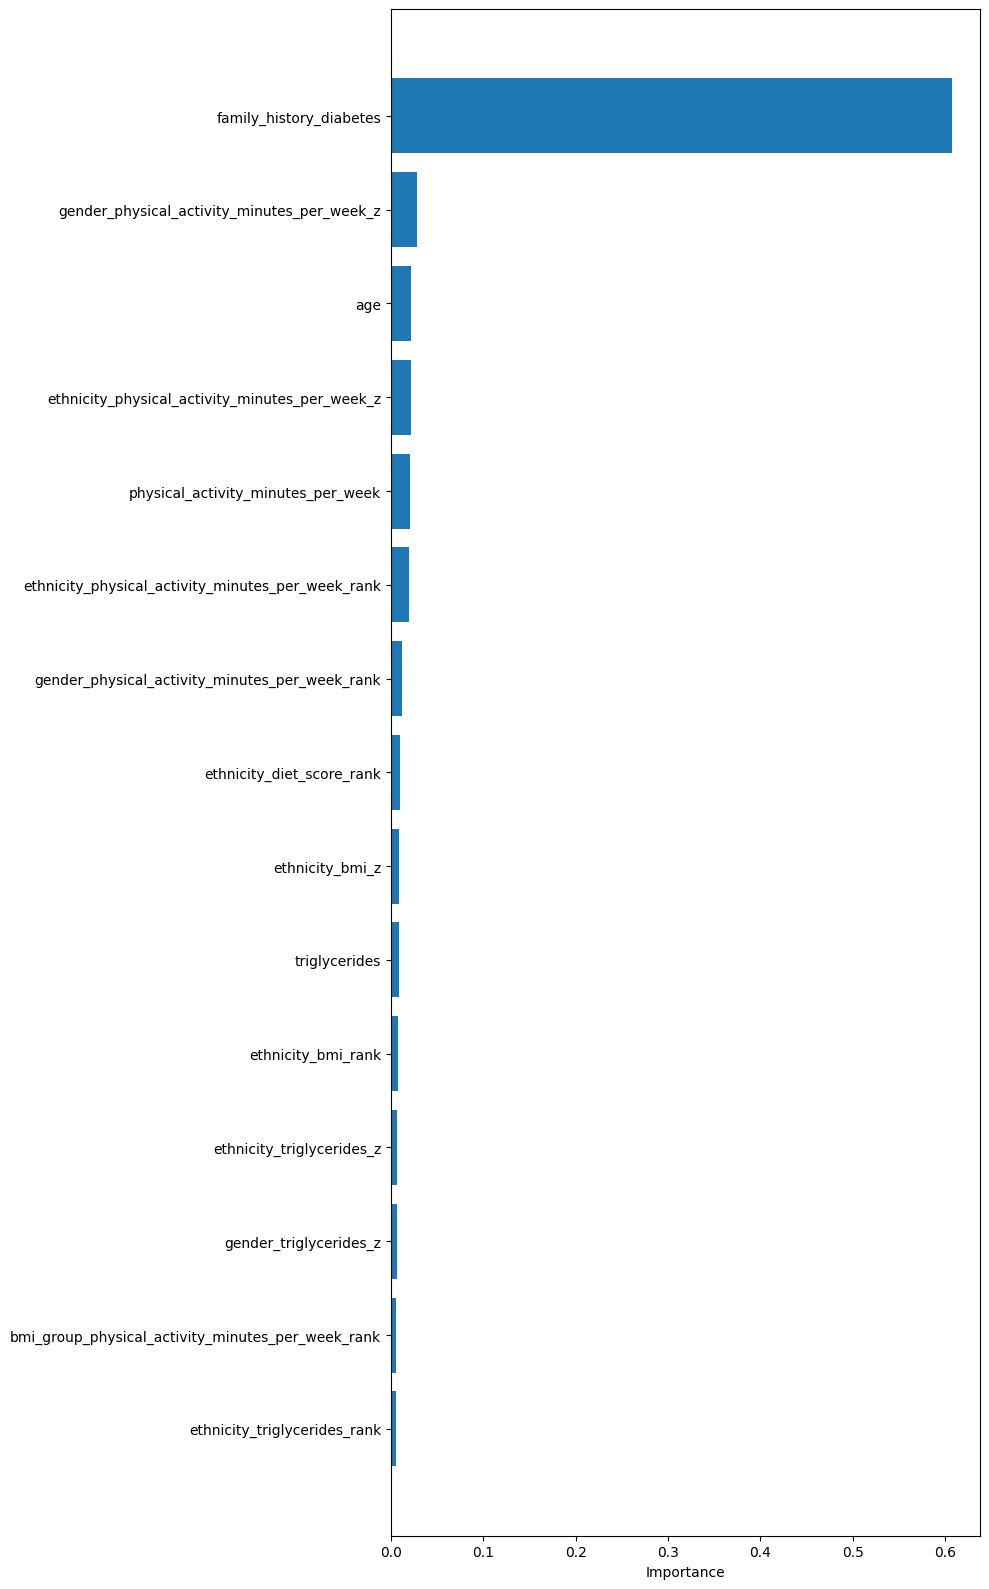

In [13]:
best_model = XGBClassifier(tree_method = 'hist', n_estimators=200, device = 'cuda' ,learning_rate=0.1, max_depth=8, reg_alpha=1.0, reg_lambda=1.0, min_child_weight=3, random_state=random_state)
best_model.fit(train_inputs, train_target)

importance_df = pd.DataFrame({
    'feature' : train_inputs.columns,
    'importance' : best_model.feature_importances_}).sort_values('importance', ascending = False)

print(importance_df.head())

plt.figure(figsize=(10, 16))
plt.barh(importance_df['feature'].head(15), 
         importance_df['importance'].head(15))
plt.xlabel('Importance') 
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [33]:
test_csv = pd.read_csv(os.path.join(data_dir, 'test.csv'))
test_id  = test_csv['id']
test_gpu = cudf.DataFrame(test_csv).drop( columns = ['id'])

display(test_gpu.head(5))

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,...,triglycerides,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history
0,45,4,100,4.3,6.8,6.2,25.5,0.84,123,70,...,111,Female,White,Highschool,Middle,Former,Employed,0,0,0
1,35,1,87,3.5,4.6,9.0,28.6,0.88,120,74,...,145,Female,White,Highschool,Middle,Never,Unemployed,0,0,0
2,45,1,61,7.6,6.8,7.0,28.5,0.94,112,71,...,184,Male,White,Highschool,Low,Never,Employed,0,0,0
3,55,2,81,7.3,7.3,5.0,26.9,0.91,114,81,...,128,Male,White,Graduate,Middle,Former,Employed,0,0,0
4,77,2,29,7.3,7.6,8.5,22.0,0.83,131,78,...,133,Male,White,Graduate,Low,Current,Unemployed,0,0,0


In [34]:
test_id

0         700000
1         700001
2         700002
3         700003
4         700004
           ...  
299995    999995
299996    999996
299997    999997
299998    999998
299999    999999
Name: id, Length: 300000, dtype: int64

In [21]:
test_gpu = labeling(test_gpu)
test_df = aggregation(test_gpu, groupby_features, measure_features)

In [22]:
test_df = get_quantiles(test_df, groupby_features, measure_features)
test_df = get_ranks(test_df, groupby_features, measure_features) 

In [23]:
test_inputs = test_df[top_feat]; del test_df

In [24]:
best_model = XGBClassifier(tree_method = 'hist', n_estimators=200, device = 'cuda' ,learning_rate=0.1, max_depth=8, reg_alpha=1.0, reg_lambda=1.0, min_child_weight=3, random_state=random_state)
best_model.fit(train_inputs, train_target)
pred       = best_model.predict(test_inputs)


In [36]:
outputs = pd.concat( [ test_id, pd.DataFrame(pred)] , axis = 1 ); display(outputs)

,id,0
0,700000,0
1,700001,1
2,700002,0
3,700003,0
4,700004,1
...,...,...
299995,999995,1
299996,999996,1
299997,999997,1
299998,999998,1


In [37]:
outputs.to_csv(os.path.join(data_dir, 'submission.csv'))